In [1]:
#allows any changes on external files to be loaded on code run.
%load_ext autoreload
%autoreload 2

# Generating Data on LUMI

In [18]:
# from GENE_ML.gene_ml.samplers.uniform import Uniform
# from GENE_ML.gene_ml.executors.ScanExecutor import ScanExecutor
# from GENE_ML.gene_ml.runners.GENErunner import GENErunner
# from GENE_ML.gene_ml.parsers.GENEparser import GENE_scan_parser

# import os
# import sys
# sys.path.append(os.path.join(os.getcwd(),'GENE_ML','enchanted-surrogates','src'))

# parameters = ['_grp_species_1-omt', '_grp_species_0-omt']
# bounds = [(4,6.7), (2.1,3.5)] #if bounds is a float rather than tuple then the sampler will make that the only value

# #Working fine
# # parameters = ['box-kymin', '_grp_species_1-omt', 'species-omn']
# # bounds = [(0.05,1), (10,70), (5,60)]

# num_samples = 5
# sampler = Uniform(parameters=parameters, bounds=bounds, num_samples=num_samples)

# ##Parser
# #The parsers main function is write_input_file
# # wite_input_file takes a parameters file from base_params_path and a set of points in the form of a dict {param1:[point1,point2...], param2:[point1,point2...]...} 
# #  It will then create a parameters file that can scan over all the points.
# base_params_path = os.path.join(os.getcwd(),'parameters_base_uq')
# remote_save_dir='/scratch/project_462000451/gene_out/gene_auto/test'
# save_dir = "/temp"
# parser = GENE_scan_parser(save_dir, base_params_path, remote_save_dir)

# ## Runner
# #The Runner is responsible for actually running a parameters file on lumi. Its main function is code_run.
# # code_run will take the set of points named samples and parse them into a parameters file.
# #  It then uses ssh to run GENE with this parametres file and a passed sbatch script.
# host = 'lumi' #needs to be configured in /home/<user>/.ssh/config
# sbatch_base_path = os.path.join('sbatch_base')
# guess_sample_wallseconds = 81 # a guess for the number of seconds it takes to run one sample.
# remote_run_dir = '/project/project_462000451/gene/'
# runner = GENErunner(parser, host, sbatch_base_path, guess_sample_wallseconds, remote_run_dir)

# ##Executor
# #The executor will divide the samples into batches; one for each worker. Each batch will be ran in paralell in seperate sbatch jobs. 
# # The executor should alter a base batch script to account for that less samples will be ran. 
# num_workers = 1
# executor = ScanExecutor(num_workers, sampler, runner, remote_save_dir=remote_save_dir)


#########################


import sys
import os
pathap = os.path.join('GENE_ML','gene_ml','static_sparse_grid_approximations')
print('PATHAP',pathap)
sys.path.append(pathap)
from GENE_ML.gene_ml.samplers.uniform import Uniform
from GENE_ML.gene_ml.datagen.datagen import DataGen
from config import config

num_samples = 200
parameters = ['_grp_species_0-omt','_grp_species_1-omt','species-omn']
bounds = [(4,6.7), (2.1,3.5), (0.16,2.9)] #if bounds is a float rather than tuple then the sampler will make that the only value
nominal = [2.7954880, 5.3871083, 1.5417906]
sampler_uniform = Uniform(parameters=parameters, num_samples=num_samples ,bounds=bounds)


remote_save_name = "UQ-DEMO-highprec-uniform"
datagen_uniform = DataGen(config, sampler_uniform, remote_save_name=remote_save_name, guess_sample_wallseconds=200, num_workers=2)

PATHAP GENE_ML/gene_ml/static_sparse_grid_approximations


In [4]:
# datagen_uniform.executor.start_runs(ex_id="ex_uniform")

EXECUTING BATCHES
Writing to /home/djdaniel/GENE_UQ/parameters_base_uq_highprec
Writing to /home/djdaniel/GENE_UQ/parameters_base_uq_highprec
PARSING SAMPLES TO INPUT FILE at temp/parameters_ex-ex_uniform_batch-0
Writing to /home/djdaniel/GENE_UQ/temp/
GENERATING SBATCH FROM PARAMETERS FILE at temp/sbatch_ex-ex_uniform_batch-0
WALL CLOCK LIMIT FOR BATCH ex-ex_uniform_batch-0:   00-07:13:20
CREATING A NEW PROBLEM DIR WITH SSH
MOVING PARAMETERS AND SBATCH FILES TO CORRECT LOCATION IN REMOTE; SUBMITTING GENE SBATCH
set lib path in ./tools/scanscript
set lib path in ./tools/scanscript
created prob01
copied parameters
created link to the GENE executable in the bin directory
Submitted batch job 7789970
JUST CREATED auto_prob_ex-ex_uniform_batch-0 in remote_run_dir
Writing to /home/djdaniel/GENE_UQ/parameters_base_uq_highprec
Writing to /home/djdaniel/GENE_UQ/parameters_base_uq_highprec
PARSING SAMPLES TO INPUT FILE at temp/parameters_ex-ex_uniform_batch-1
Writing to /home/djdaniel/GENE_UQ/te

# Pulling Data from LUMI

The data loaded was created by scanning over ion and electron temperature gradients within their margin of uncertainty. 

In [26]:
from GENE_ML.gene_ml.dataset.ScanData import ScanData
from config import config
data_name = '200s_3p_uq-highprec'
test_percentage=50

data_set_uniform = ScanData(data_name, datagen_uniform.parser, config.host, remote_path=datagen_uniform.remote_save_dir, test_percentage=test_percentage)

Initialising dataset
SSH PATH lumi1:/scratch/project_462000451/gene_out/gene_auto/UQ-DEMO-highprec-uniform

LOADING FROM SCANLOG DIR

LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/200s_3p_uq-highprec/scan_batch-0_0.log

LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/200s_3p_uq-highprec/scan_batch-1_0.log

200 SAMPLES RAN OUT OF 200 BEFORE MAX WALLTIME:
NUMBER OF SAMPLES AFTER REMOVING NaN's: 200
NaN PERCENTAGE =  0.0

RANDOMLY SPLITTING DATA INTO TEST AND TRAINING SETS: 50% test, 50 training.


In [39]:
print(np.any(data_set_uniform.df['growthrate']))

print(data_set_uniform.x_train[0])

        omt2      omt1      omn1 growthrate frequency
0   2.484996  4.499231  0.883268   0.099887  0.096284
1   2.934477  4.539037  1.456623   0.102207  0.058905
2   3.051881  6.083308  1.966819   0.135272  0.042262
3   2.858069  5.836209  1.272154   0.132430  0.083876
4   2.664542  5.275577  0.202671   0.112418  0.144319
..       ...       ...       ...        ...       ...
95  3.417640  6.094214  0.632766   0.137802  0.121628
96  3.173110  6.183974  2.193758   0.135426  0.027724
97  3.008549  4.876698  2.101325   0.103935  0.020260
98  2.399705  4.656747  0.177257   0.096337  0.141250
99  2.340663  4.429617  1.062899   0.098388  0.085409

[200 rows x 5 columns]
[2.518653 5.100391 1.474128]


# Training Surrogate Model 

In [28]:
import os
from GENE_ML.gene_ml.models.GPR import GPR
from GENE_ML.gene_ml.results.results import Results

#numsamples_numparameters_model_testpercentage
model_name = 'GPR'
results_gpr_name = 'UQ-DEMO_results_100s_3p_GPR_50tp'
#results_gpr_name = f'uq_results_{num_samples}s_{len(parameters)}p_{model_name}_{test_percentage}tp' #
results_gpr = Results(results_gpr_name)
gpr = GPR(name = model_name)
print(gpr.parent)
if os.path.exists(results_gpr.path) and os.path.exists(gpr.path):
    print('\nLOADING RESULTS FROM FILE\n')
    results_gpr = results_gpr.load()
    print(f'{results_gpr.name} IS LOADED')
    gpr = gpr.load()
else:
    print('\nCOMPUTING RESULTS\n')
    #Sampling already done, gene has been ran
    gpr.train(data_set_uniform.x_train, data_set_uniform.growthrate_train)
    gpr.tune_hypers(data_set_uniform.x_train, data_set_uniform.growthrate_train)

    results_gpr.growthrate_predict_seen, growthrate_predict_seen_errors = gpr.predict(data_set_uniform.x_train)
    results_gpr.growthrate_predict_unseen, growthrate_predict_unseen_errors = gpr.predict(data_set_uniform.x_test)

    results_gpr.save()

parent

COMPUTING RESULTS

GPR is a parameterless approach and does not have a training step. Instead the hyperparameters are tuned to the data.
OPTIMISING THE HYPERPERS
CURRENT HYPERS:
 
Name : GP regression
Objective : 94.73476072451719
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (3,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        
OPTIMISING THE HYPERPERS:
Optimization restart 1/3, f = -497.6366856202331
Optimization restart 2/3, f = -509.10284826618033
Optimization restart 3/3, f = -509.1028482883137
RESULTING HYPERS:
 
Name : GP regression
Objective : -509.1028482883137
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf

NO UNCERTAINTY PROVIDED
NO UNCERTAINTY PROVIDED


 /tmp/ipykernel_156028/2357624553.py:20: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown


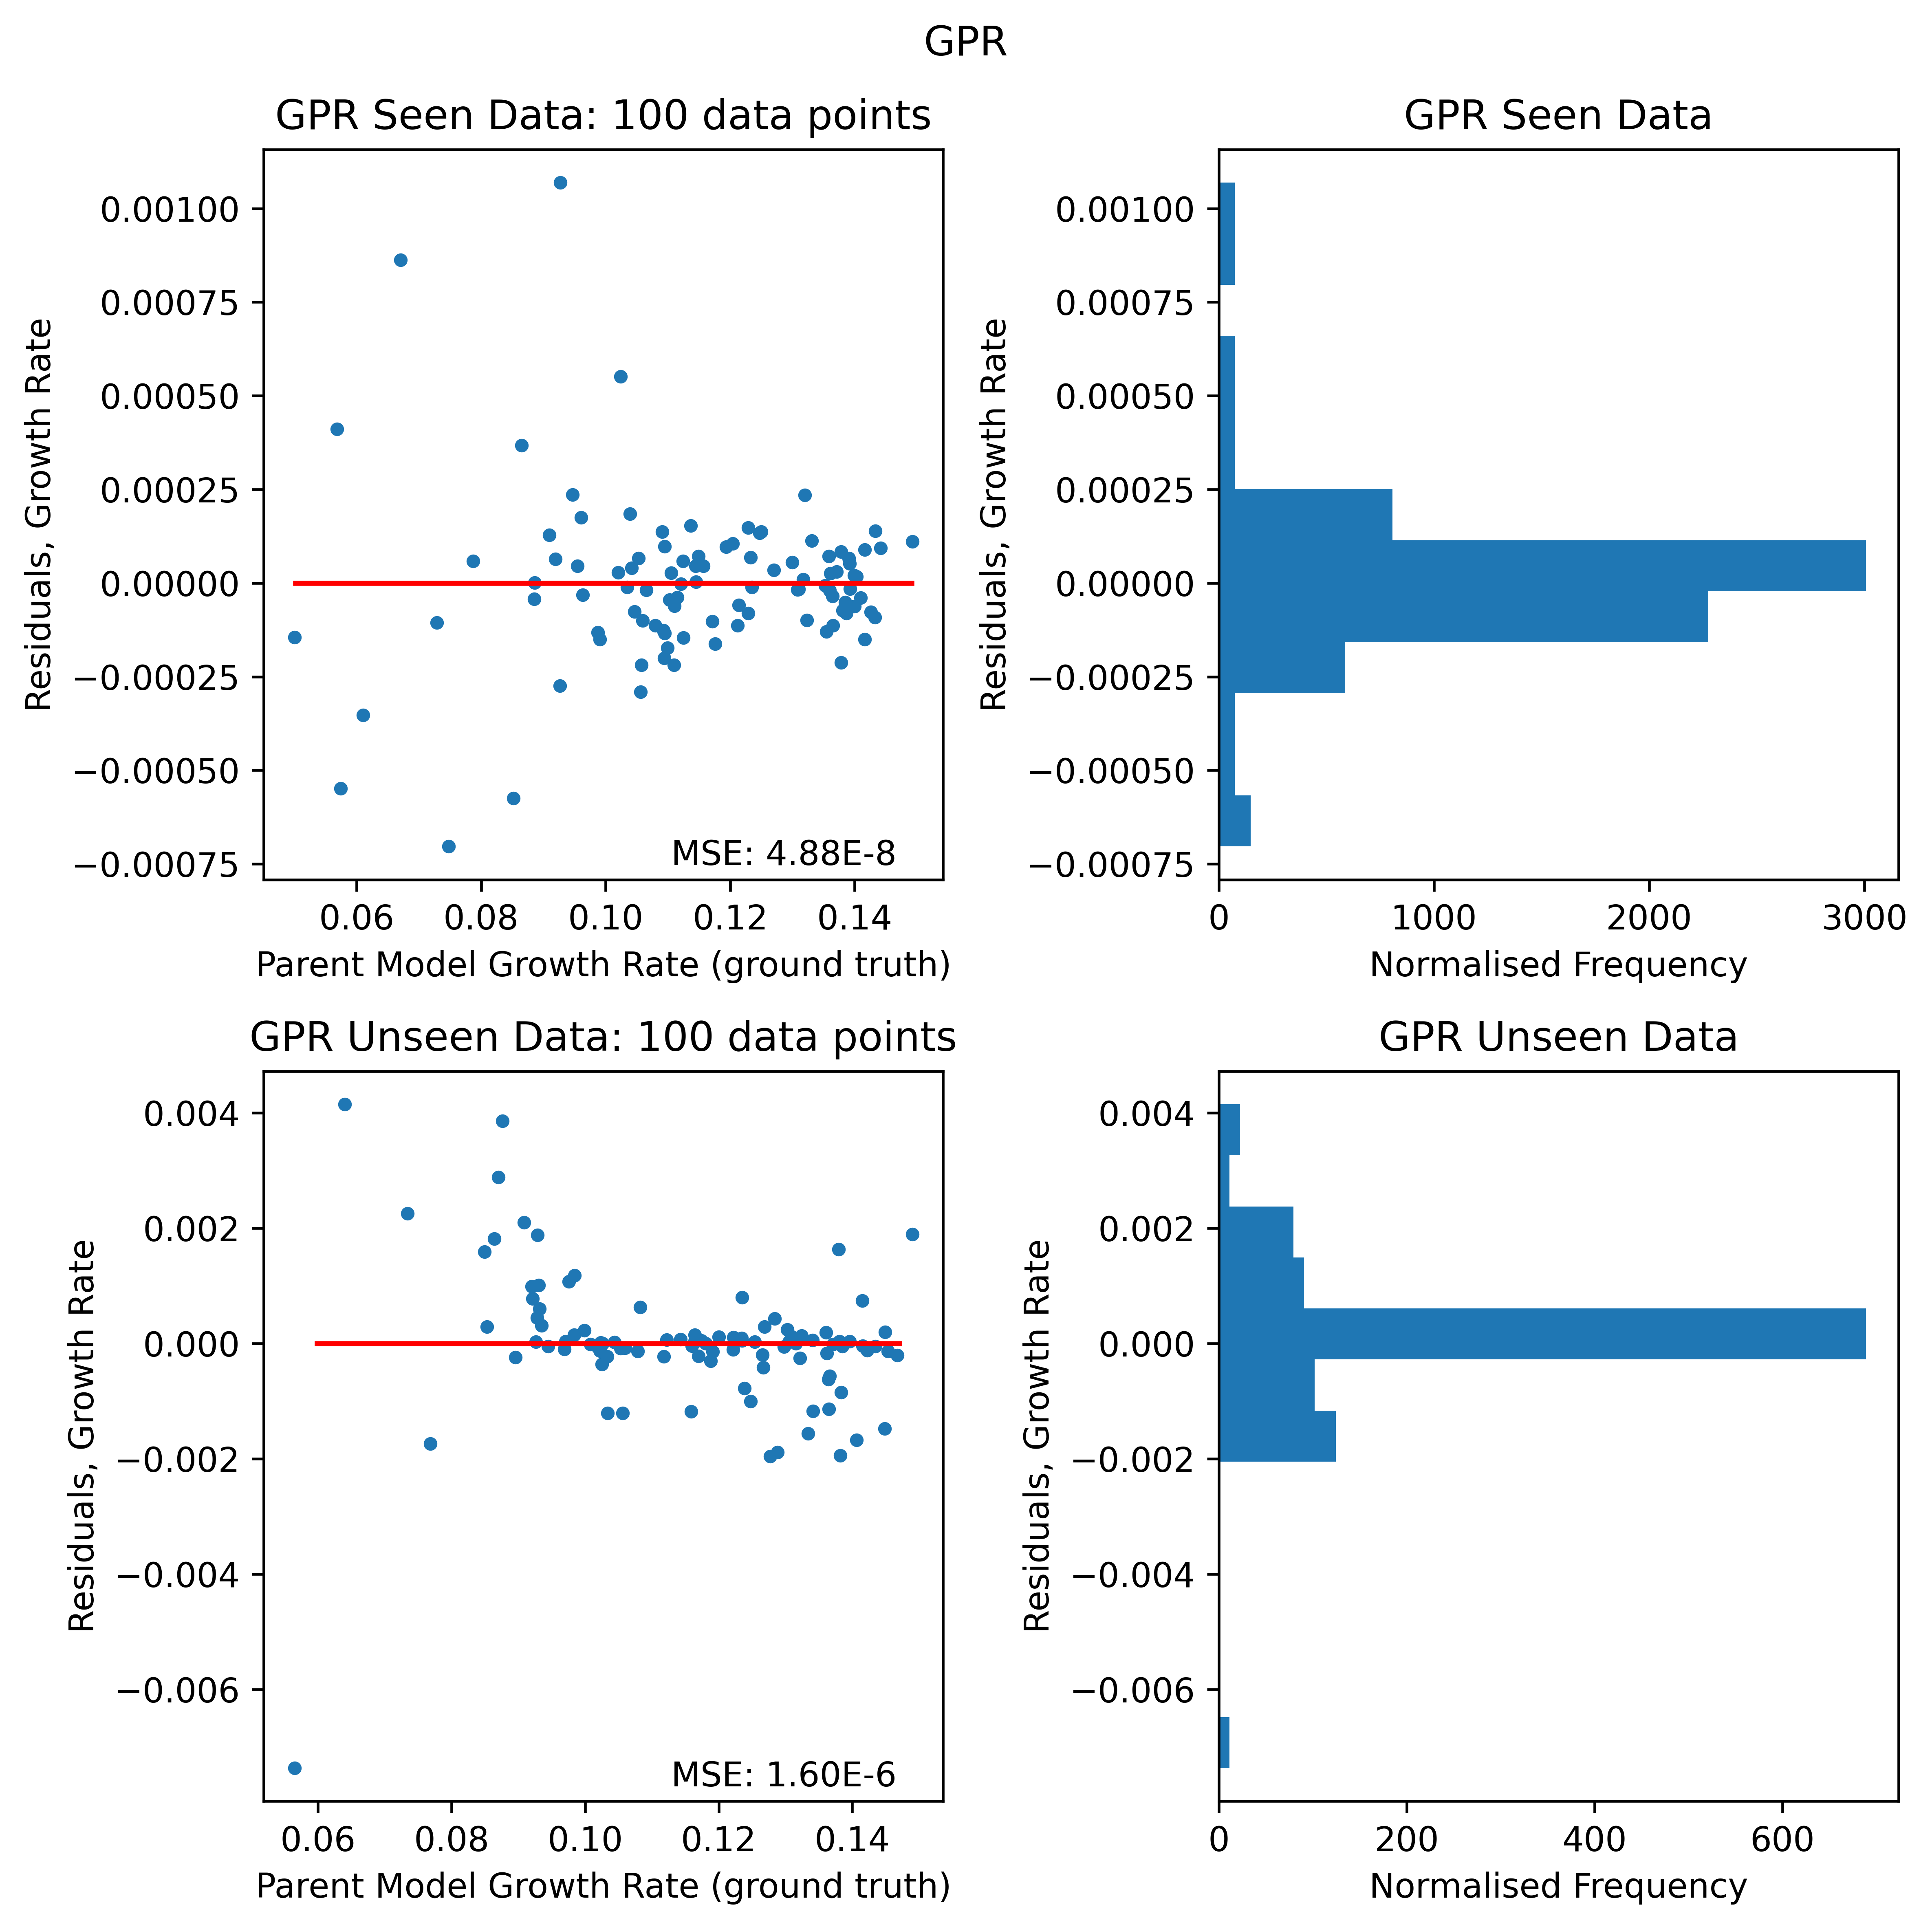

In [29]:
import matplotlib.pyplot as plt
from GENE_ML.gene_ml import visualise as vis

ncol=2
nrow=2
size=4
model_name = 'GPR'
fig_residuals, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrow,ncol, figsize=(size*ncol,size*nrow), dpi=600)
    
vis.residual_plot(ax1, fig_residuals, data_set_uniform.growthrate_train, results_gpr.growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')#, y_pred_err=growthrate_predict_seen_errors)
vis.residual_hist(ax2, fig_residuals, data_set_uniform.growthrate_train, results_gpr.growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data', bins=13)

vis.residual_plot(ax3, fig_residuals, data_set_uniform.growthrate_test, results_gpr.growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')#, y_pred_err=growthrate_predict_unseen_errors)
vis.residual_hist(ax4, fig_residuals, data_set_uniform.growthrate_test, results_gpr.growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data', bins=13)

# ax4.sharex(ax2)

fig_residuals.suptitle(model_name)
fig_residuals.tight_layout()
fig_residuals.show()

In [40]:
import numpy as np
from GENE_ML.gene_ml.samplers.gaussian import Gaussian

#swapped omts as they appeared in different order in dataset
bounds2 = [(2.1,3.5), (4,6.7), (0.16,2.9)] #if bounds is a float rather than tuple then the sampler will make that the only value
parameters2 = ['_grp_species_1-omt','_grp_species_0-omt','species-omn']
num_samples_g = 100000
gaussian = Gaussian(bounds2, num_samples_g, parameters2)
gaussian.samples_np

array([[2.51804697, 4.78538347, 1.15137538],
       [2.45458912, 5.49310162, 1.51219068],
       [2.91709763, 4.52863338, 3.24381748],
       ...,
       [2.66547217, 5.63319572, 1.72034748],
       [2.78275913, 4.52618974, 0.29039106],
       [2.37904285, 5.13477867, 0.62166332]])

In [42]:
print(gaussian.samples_np.shape)
print(data_set_uniform.x_train.shape)

print(gaussian.parameters)
print(data_set_uniform.df.head(1))



(100000, 3)
(100, 3)
['_grp_species_1-omt', '_grp_species_0-omt', 'species-omn']
       omt2      omt1      omn1 growthrate frequency
0  2.484996  4.499231  0.883268   0.099887  0.096284


[[2.518653 5.100391 1.474128]
 [2.763043 4.066328 2.867899]
 [2.594635 6.190552 1.927952]
 [2.35727  6.19004  1.175926]
 [2.877786 6.528088 2.870832]
 [2.225807 6.352249 2.179674]
 [2.982421 4.919742 1.568558]
 [3.17311  6.183974 2.193758]
 [2.520831 5.650782 1.419675]
 [3.401566 6.317828 2.128638]]
[0.114513 0.056868 0.136432 0.137804 0.130828 0.136128 0.111074 0.135426
 0.127031 0.139953]
SHAPE (1, 3) (100, 3)


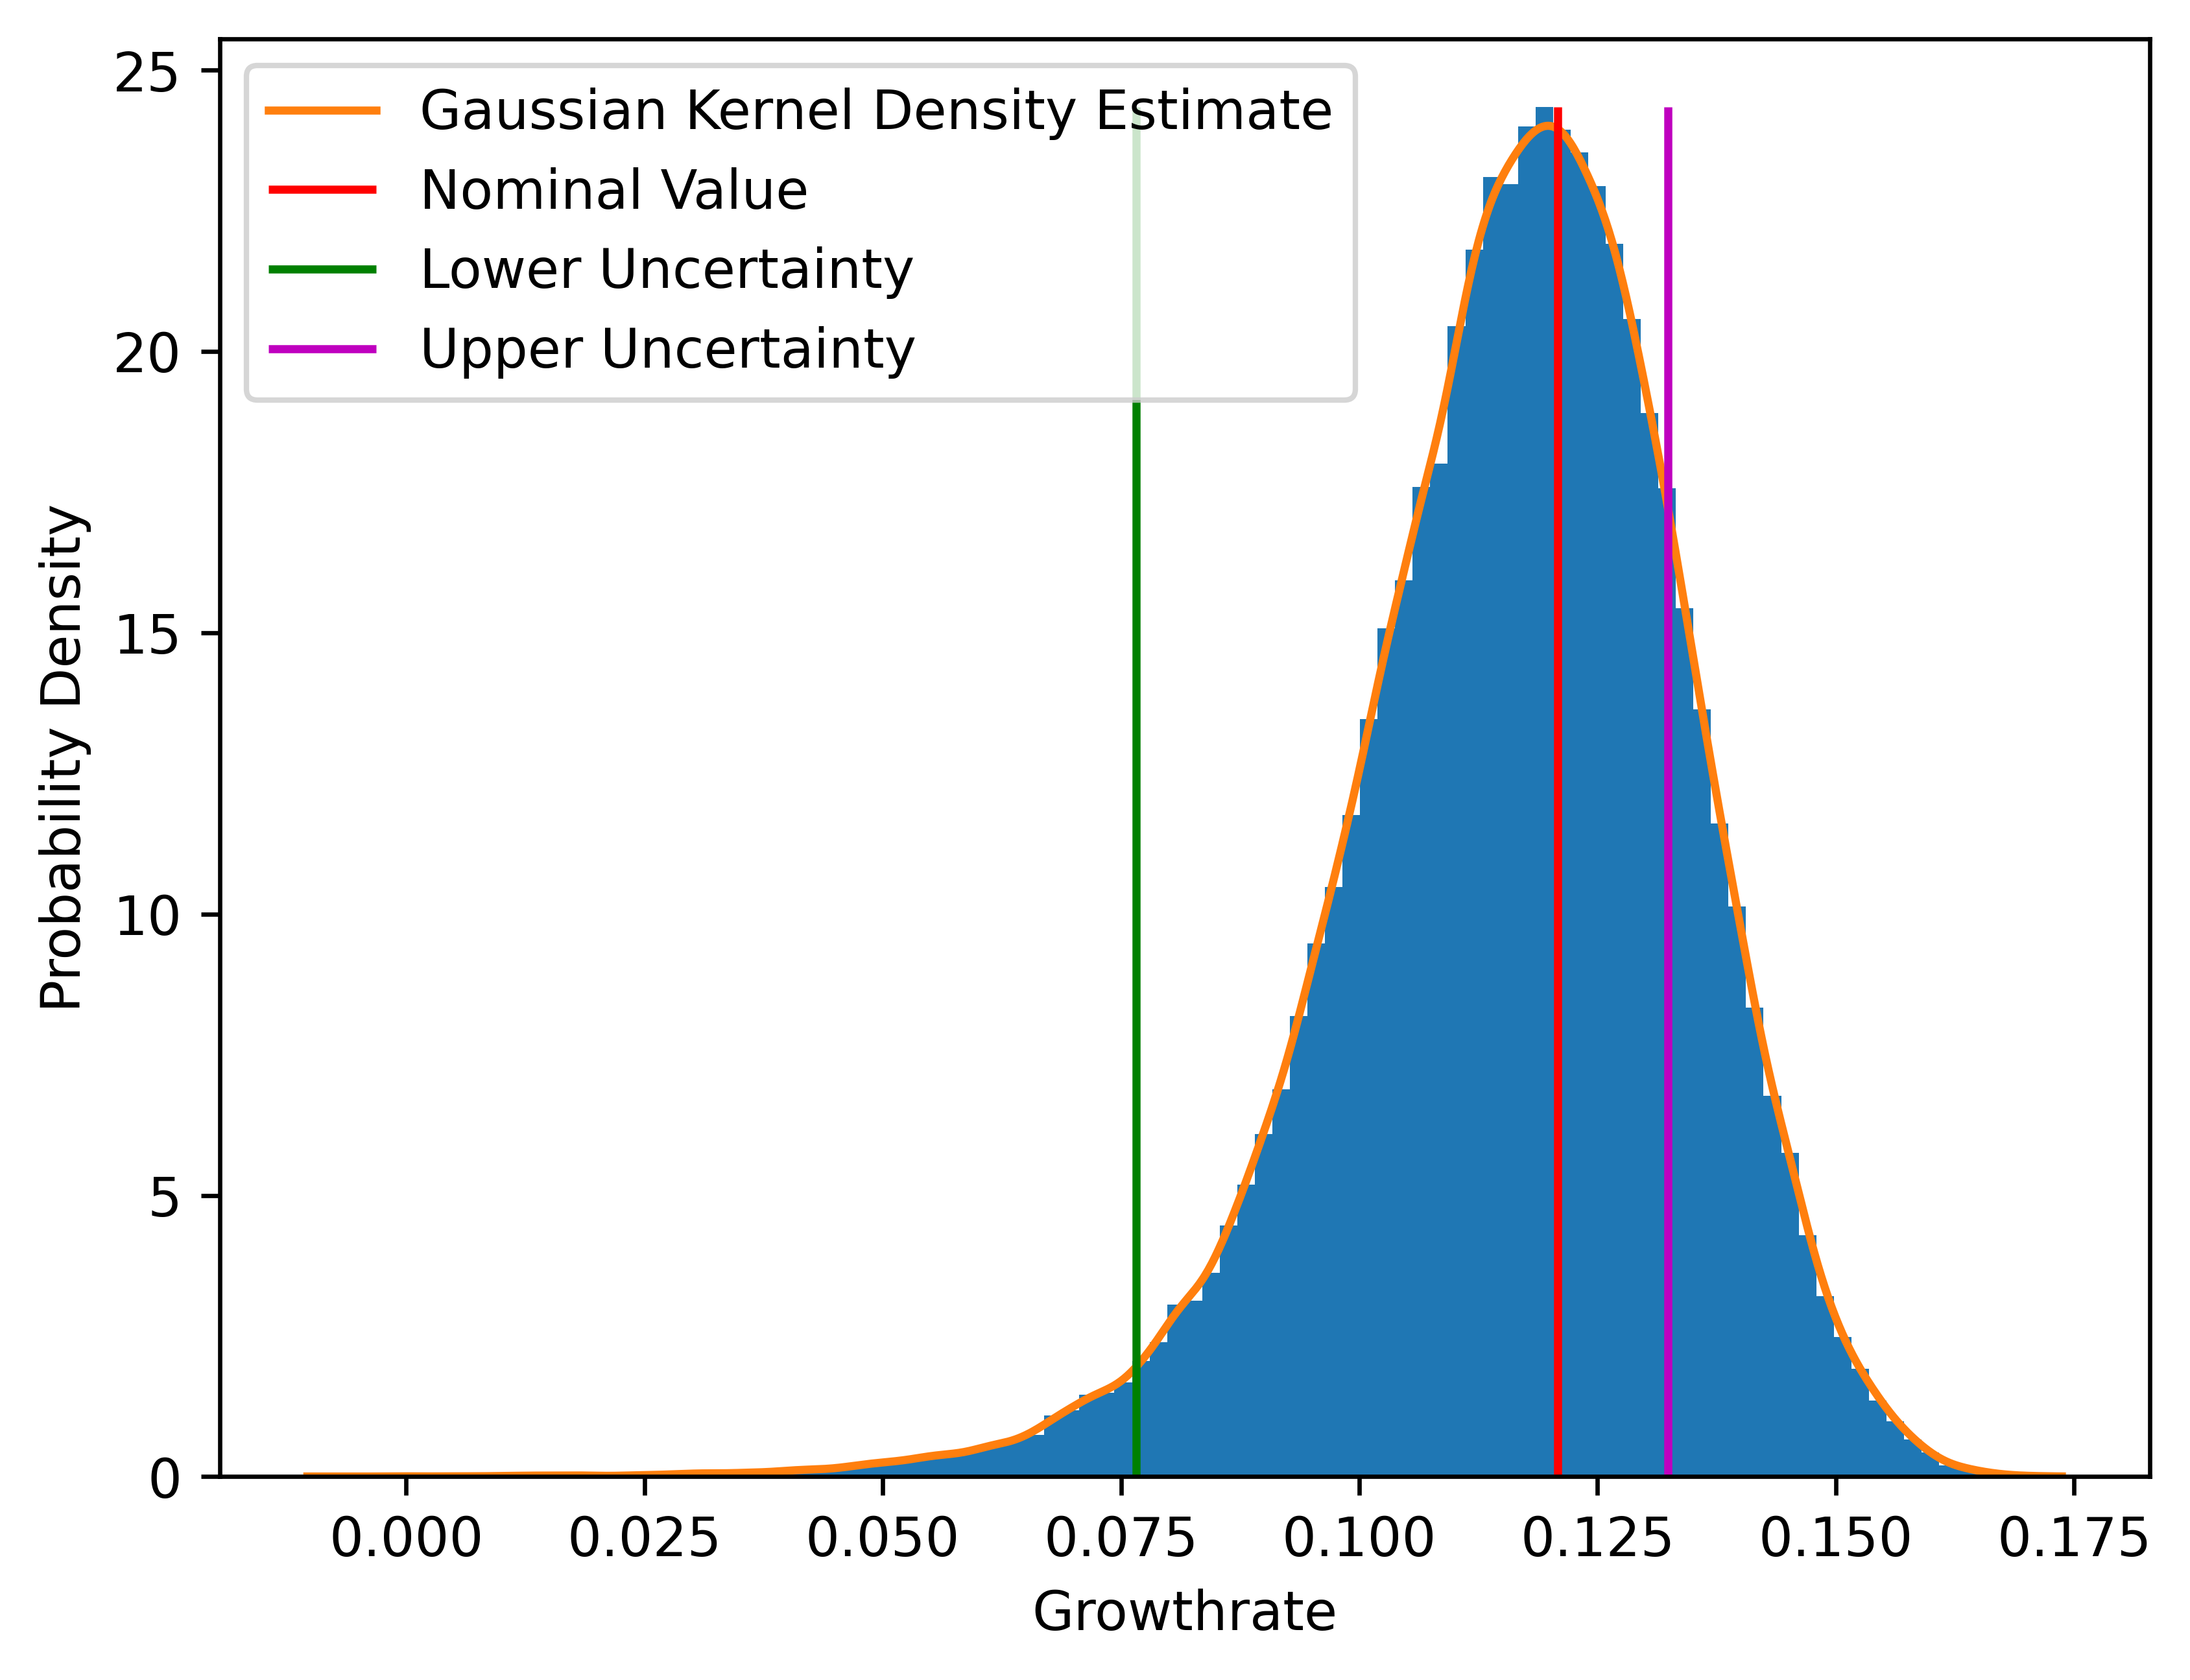

In [44]:
from scipy import stats
growthrates, _ = gpr.predict(gaussian.samples_np)
print(data_set_uniform.x_train[0:10])
print(data_set_uniform.growthrate_train[0:10])

nominal_parameters = np.array([np.mean(b) for b in bounds2]).reshape((len(bounds2),1)).T
print('SHAPE', nominal_parameters.shape, data_set_uniform.x_train.shape)
nominal_growthrate, _ = gpr.predict(nominal_parameters)
left_bound_gr, _ = gpr.predict(np.array([b[0] for b in bounds2]).reshape(len(bounds2),1).T)
right_bound_gr, _ = gpr.predict(np.array([b[1] for b in bounds2]).reshape(len(bounds2),1).T)

fig = plt.figure(dpi=600)
kde = stats.gaussian_kde(growthrates)
hist_x = np.linspace(np.min(growthrates),np.max(growthrates), 1000)
n, bins, _ = plt.hist(growthrates, bins=100, density=True)
plt.plot(hist_x, kde(hist_x), label='Gaussian Kernel Density Estimate')
plt.xlabel('Growthrate')
plt.ylabel('Probability Density')
plt.vlines(nominal_growthrate, 0, max(n), 'r', label='Nominal Value')
plt.vlines(left_bound_gr, 0, max(n), 'g', label='Lower Uncertainty')
plt.vlines(right_bound_gr, 0, max(n), 'm', label='Upper Uncertainty')
# plt.annotate(fr'$\nabla T_e$: {nominal_parameters[0][0]}$\pm$1.35  -  $\nabla T_i$: {nominal_parameters[0][1]}$\pm$0.7  -  Gaussian Error 95% Confidance',
            # xy=(0, 1.01), xycoords='axes fraction',fontsize=10)

plt.legend()
plt.show()


In [49]:
import numpy as np
from GENE_ML.gene_ml.samplers.uniform import Uniform

num_samples_u = 100000
uniform = Uniform(bounds2, num_samples_u, parameters2)

uniform.samples_array.shape

(100000, 3)

[[2.518653 5.100391 1.474128]
 [2.763043 4.066328 2.867899]
 [2.594635 6.190552 1.927952]
 [2.35727  6.19004  1.175926]
 [2.877786 6.528088 2.870832]
 [2.225807 6.352249 2.179674]
 [2.982421 4.919742 1.568558]
 [3.17311  6.183974 2.193758]
 [2.520831 5.650782 1.419675]
 [3.401566 6.317828 2.128638]]
[0.114513 0.056868 0.136432 0.137804 0.130828 0.136128 0.111074 0.135426
 0.127031 0.139953]
SHAPE (1, 3) (100, 3)


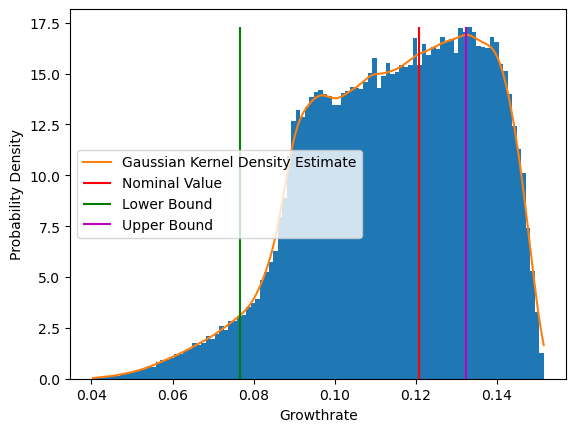

In [51]:
from scipy import stats
growthrates, _ = gpr.predict(uniform.samples_array)
print(data_set_uniform.x_train[0:10])
print(data_set_uniform.growthrate_train[0:10])

nominal_parameters = np.array([np.mean(b) for b in bounds2]).reshape((len(bounds2),1)).T
print('SHAPE', nominal_parameters.shape, data_set_uniform.x_train.shape)
nominal_growthrate, _ = gpr.predict(nominal_parameters)
left_bound_gr, _ = gpr.predict(np.array([b[0] for b in bounds2]).reshape(len(bounds2),1).T)
right_bound_gr, _ = gpr.predict(np.array([b[1] for b in bounds2]).reshape(len(bounds2),1).T)

kde = stats.gaussian_kde(growthrates)
hist_x = np.linspace(np.min(growthrates),np.max(growthrates), 1000)
n, bins, _ = plt.hist(growthrates, bins=100, density=True)
plt.plot(hist_x, kde(hist_x), label='Gaussian Kernel Density Estimate')
plt.xlabel('Growthrate')
plt.ylabel('Probability Density')
plt.vlines(nominal_growthrate, 0, max(n), 'r', label='Nominal Value')
plt.vlines(left_bound_gr, 0, max(n), 'g', label='Lower Bound')
plt.vlines(right_bound_gr, 0, max(n), 'm', label='Upper Bound')
# plt.annotate(f'ETG: {nominal_parameters[0][0]}$\pm$1.35  -  ITG: {nominal_parameters[0][1]}$\pm$0.7  -  Bounded Uniform Error',
#             xy=(0, 1.01), xycoords='axes fraction',fontsize=10)

plt.legend()
plt.show()

